## 3D Convolutions : Understanding + Use Case - Drug Discovery

<br>
In one of my previous [kernel](https://www.kaggle.com/shivamb/a-very-comprehensive-tutorial-nn-cnn), I have shared the working of convolutional neural networks for images. In this kernel, I have explained 3D convolutions and their implementation on 3D MNIST dataset. Later in this kernel, I have shown how to use 3D convolution layers on one of the breakthrough and important area of Healthcare : Drug Discovery

### What are Convolutions? 

- Mathematically, A convolution is an integration function that expresses the amount of overlap of one function g as it is shifted over another function f.   
- Intutively, A convolution acts as a blender that mixes one function with another to give reduced data space while preserving the information.    

In terms of Neural Networks and Deep Learning:
- Convolutions are filter (matrix / vectors) with learnable parameters that are used to extract low-dimentional features from an input data.     
- They have the property to preserve the spatial or positional relationships between input data points  
- Convolutional neural networks exploits the spatially-local correlation by enforcing a local connectivity pattern between neurons of adjacent layers.    
- Intutively, convolution is the step of applying the concept of sliding window (a filter with learnable weights) over the input and producing a weighted sum (of weights and input) as the output. The weighted sum is the feature space which is used as the input for the next layers.  

For example, in Face Recognization problem, first few convolution layers learns the pressence of key points in the input image, next convolution layers learns the edges and shapes, and final convolution layers learns the face.  In this example, the input space is first reduced to lower dimentional space (representing information about points / pixels), then this space is reduced to another space containing (edges / shapes) and finally it is reduced to classify faces in the images. Convolutions can be applied in N dimentions.  

### Types of Convolutions : 

Let's discuss what are different types of convolutions 

### 1D Convolutions

Most simplistic convolutions are 1D convolutionals are generally used on sequence datasets (but can be used for other use-cases as well). They can be used for extracting local 1D subsequences from the input sequences and identify local patterns within the window of convolution. The following image shows how a 1 D convolution filter is applied to a sequence to obtain new features. Other common uses of 1D convolutions are seen in the area of NLP where every sentence is represented as a sequence of words.  

<br><br>

![](https://i.imgur.com/5UQz1zI.jpg)


### 2D Convolutions 

On image datasets, mostly 2D Convolutional filters are used in CNN architectures. The main idea of 2D convolutions is that the the convolutional filter moves in 2-directions (x,y) to calculate low dimentional features from the image data. The output shape is also a 2 dimentional matrix. 

![](https://www.andrewszot.com/static/img/ml/cnn/pooling.png)

### 3D Convolutions

3D convolutions applies a 3 dimentional filter to the dataset and the filter moves 3-direction (x, y, z) to calcuate the low level feature representations. Their output shape is a 3 dimentional volume space such as cube or cuboid. They are helpful in event detection in videos, 3D medical images etc. They are not limited to 3d space but can also be applied to 2d space inputs such as images.  

![](https://i.imgur.com/jriyCTU.png?1)

Lets implement the 3D CNN on 3D Mnist dataset. First, lets import the key libraries. 

Additionally, there are other types of convolutions as well: 

### Dilated Convolutions  

Dilated or Altrous convolutions defines the spacing between the values in a kernel. In this type of convolution, the receptive view of the kernels increases due to the spacing, For example a 3x3 kernel with a dilation rate of 2 will have the same field of view as a 5x5 kernel. The complexity remains the same but different features are generated in this case. 

![](https://qph.fs.quoracdn.net/main-qimg-d9025e88d7d792e26f4040b767b25819)

Let's now create a 3D convolutional neural network architecture on 3D mnist dataset. 

In [1]:
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py

init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


# Step 1: Familiarize ourselves with shape of data
The 3D MNIST data is given in the .h5 format, lets load the complete dataset into training and test sets. 

In [2]:
with h5py.File('../input/full_dataset_vectors.h5', 'r') as dataset: #HDF5 is a file format commonly used for storing and organizing large datasets.
    x_train = dataset["X_train"][:]
    x_test = dataset["X_test"][:]
    y_train = dataset["y_train"][:]
    y_test = dataset["y_test"][:]

Lets look at the dataset dimentions

In [3]:
print ("x_train shape: ", x_train.shape)
print ("y_train shape: ", y_train.shape)

print ("x_test shape:  ", x_test.shape)
print ("y_test shape:  ", y_test.shape)

x_train shape:  (10000, 4096)
y_train shape:  (10000,)
x_test shape:   (2000, 4096)
y_test shape:   (2000,)


This dataset is a flat one dimentional data, but the author of this dataset has also shared the original x,y,z in a separate data file. Lets plot a digits in 3D space. Rotate this 3D digit to view it properly. 

In [4]:
%whos

Variable                   Type        Data/Info
------------------------------------------------
Adadelta                   type        <class 'keras.optimizers.Adadelta'>
BatchNormalization         type        <class 'keras.layers.norm<...>tion.BatchNormalization'>
Conv3D                     type        <class 'keras.layers.convolutional.Conv3D'>
Dense                      type        <class 'keras.layers.core.Dense'>
Dropout                    type        <class 'keras.layers.core.Dropout'>
Flatten                    type        <class 'keras.layers.core.Flatten'>
Input                      function    <function Input at 0x78e304955d90>
MaxPool3D                  type        <class 'keras.layers.pooling.MaxPooling3D'>
Model                      type        <class 'keras.engine.training.Model'>
accuracy_score             function    <function accuracy_score at 0x78e2f3c83d90>
categorical_crossentropy   function    <function categorical_cro<...>ntropy at 0x78e3048bebf8>
cm            

# Step 2: Import and Visualize Data

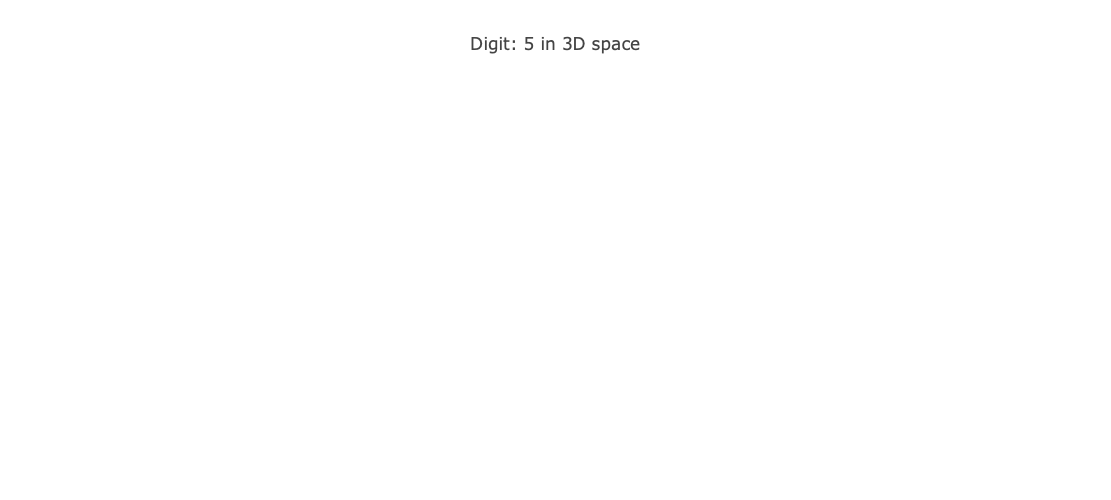

In [5]:
with h5py.File("../input/train_point_clouds.h5", "r") as points_dataset:        
    digits = []
    for i in range(10):
        digit = (points_dataset[str(i)]["img"][:], 
                 points_dataset[str(i)]["points"][:], 
                 points_dataset[str(i)].attrs["label"]) 
        digits.append(digit) # Appends the img, points, and label columns from the h5py file
        
x_c = [r[0] for r in digits[0][1]] #Selects the first item (x) in the 'points' category from above
y_c = [r[1] for r in digits[0][1]]
z_c = [r[2] for r in digits[0][1]]
trace1 = go.Scatter3d(x=x_c, y=y_c, z=z_c, mode='markers', 
                      marker=dict(size=12, color=z_c, colorscale='Viridis', opacity=0.0))

data = [trace1]
layout = go.Layout(height=500, width=600, title= "Digit: "+str(digits[0][2]) + " in 3D space")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Now, lets implement a 3D convolutional Neural network on this dataset.  To use 2D convolutions, we first convert every image into a 3D shape : width, height, channels. Channels represents the slices of Red, Green, and Blue layers. So it is set as 3. In the similar manner, we will convert the input dataset into 4D shape in order to use 3D convolution for : length, breadth, height, channel (r/g/b). 

In [6]:
## Introduce the channel dimention in the input dataset 
xtrain = np.ndarray((x_train.shape[0], 4096, 3)) # (samples, points, rgb channels) – points are originally in a list of 4096, and they need to be organized into x,y,and z
xtest = np.ndarray((x_test.shape[0], 4096, 3))

## iterate in train and test, add the rgb dimention 
def add_rgb_dimention(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array
for i in range(x_train.shape[0]):
    xtrain[i] = add_rgb_dimention(x_train[i])
for i in range(x_test.shape[0]):
    xtest[i] = add_rgb_dimention(x_test[i])

## convert to 1 + 4D space (1st argument represents number of rows in the dataset)
xtrain = xtrain.reshape(x_train.shape[0], 16, 16, 16, 3) # splits the 4096 (16^3) points into a 16x16x16 grid in a 3D space, with each grid cell having RGB color information. 
xtest = xtest.reshape(x_test.shape[0], 16, 16, 16, 3)

## convert target variable into one-hot
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [7]:
%whos

Variable                   Type         Data/Info
-------------------------------------------------
Adadelta                   type         <class 'keras.optimizers.Adadelta'>
BatchNormalization         type         <class 'keras.layers.norm<...>tion.BatchNormalization'>
Conv3D                     type         <class 'keras.layers.convolutional.Conv3D'>
Dense                      type         <class 'keras.layers.core.Dense'>
Dropout                    type         <class 'keras.layers.core.Dropout'>
Flatten                    type         <class 'keras.layers.core.Flatten'>
Input                      function     <function Input at 0x78e304955d90>
MaxPool3D                  type         <class 'keras.layers.pooling.MaxPooling3D'>
Model                      type         <class 'keras.engine.training.Model'>
accuracy_score             function     <function accuracy_score at 0x78e2f3c83d90>
add_rgb_dimention          function     <function add_rgb_dimention at 0x78e2f2853a60>
categorica

In [8]:
y_train.shape

(10000, 10)

# Step 3: Create Model Architeceture
The architecture is described below: 

Input and Output layers: 
- One Input layer with dimentions 16, 16, 16, 3  
- Output layer with dimentions 10  

Convolutions : 
- Apply 4 Convolutional layer with increasing order of filter size (standard size : 8, 16, 32, 64) and fixed kernel size = (3, 3, 3)
- Apply 2 Max Pooling layers, one after 2nd convolutional layer and one after fourth convolutional layer.  

MLP architecture: 
- Batch normalization on convolutiona architecture  
- Dense layers with 2 layers followed by dropout to avoid overfitting  


In [9]:
## input layer
input_layer = Input((16, 16, 16, 3))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(2, 2, 2), activation='relu')(input_layer)
conv_layer1 = BatchNormalization()(conv_layer1)

conv_layer2 = Conv3D(filters=16, kernel_size=(2, 2, 2), activation='relu')(conv_layer1)
conv_layer2 = BatchNormalization()(conv_layer2)

## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=32, kernel_size=(2, 2, 2), activation='relu')(pooling_layer1)
conv_layer3 = BatchNormalization()(conv_layer3)
conv_layer4 = Conv3D(filters=64, kernel_size=(2, 2, 2), activation='relu')(conv_layer3)
conv_layer4 = BatchNormalization()(conv_layer4)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer2 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer2)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.6)(dense_layer1)
dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.6)(dense_layer2)
output_layer = Dense(units=10, activation='softmax')(dense_layer2)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 16, 16, 3)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 15, 15, 8)     200       
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 15, 8)     32        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 14, 14, 14, 16)    1040      
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 14, 16)    64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 7, 7, 16)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 6, 6, 6, 32)       4128      
__________

# Compile the model and start training. 

In [10]:
model.compile(loss=categorical_crossentropy, optimizer=Adadelta(lr=0.1), metrics=['acc'])
history = model.fit(x=xtrain, y=y_train, batch_size=128, epochs=30, validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 9s 1ms/step - loss: 2.4690 - acc: 0.1775 - val_loss: 1.8299 - val_acc: 0.4120
Epoch 2/30
8000/8000 [==============================] - 2s 241us/step - loss: 1.9701 - acc: 0.3185 - val_loss: 1.5875 - val_acc: 0.4885
Epoch 3/30
8000/8000 [==============================] - 2s 241us/step - loss: 1.7476 - acc: 0.3962 - val_loss: 1.4418 - val_acc: 0.5235
Epoch 4/30
8000/8000 [==============================] - 2s 239us/step - loss: 1.5717 - acc: 0.4529 - val_loss: 1.3619 - val_acc: 0.5455
Epoch 5/30
8000/8000 [==============================] - 2s 256us/step - loss: 1.4752 - acc: 0.4869 - val_loss: 1.3024 - val_acc: 0.5610
Epoch 6/30
8000/8000 [==============================] - 2s 246us/step - loss: 1.4061 - acc: 0.5135 - val_loss: 1.2510 - val_acc: 0.5700
Epoch 7/30
8000/8000 [==============================] - 2s 243us/step - loss: 1.3338 - acc: 0.5375 - val_loss: 1.2250 - val_acc: 0.5830
Ep

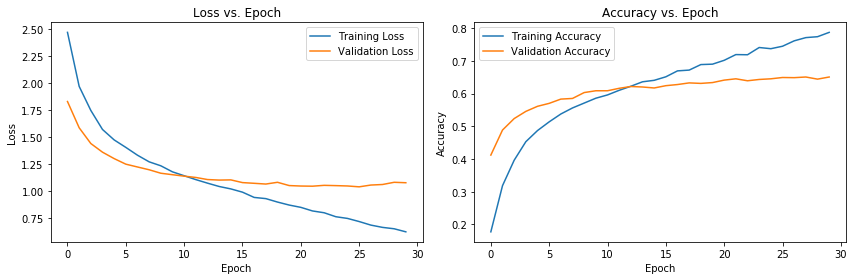

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# ____See if we can improve our accuracy with data augmentation

In the model training, we can observe that the accuracy on validation set is fluctuating which suggests that the network can be improved further. Let's predict and measure the accuracy of current model

# Make Confusion Matrix and Display Accuracy

In [13]:
pred = model.predict(xtest)
pred_numerical = np.argmax(pred, axis=1)
y_test_numerical = np.argmax(y_test, axis=1)

print(len(y_test_numerical))
print(pred.shape)


correct, incorrect = 0,0
for i in range(len(pred_numerical)):
    if y_test_numerical[i] == pred_numerical[i]:
        correct += 1
    else:
        incorrect += 1
print('Accuracy',(correct)/(correct+incorrect))

2000
(2000, 10)
Accuracy 0.647


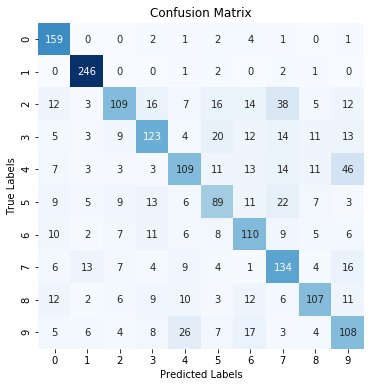

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test_numerical and pred_numerical are your lists of predictions and true labels
# You can replace them with your actual data

# Create the confusion matrix
cm = confusion_matrix(y_test_numerical, pred_numerical)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


The model is not accurate at this point of time, But it can be improved further with architectural changes and hyperparameter tuning. 

## Use Case : Drug Discovery using 3D CNN

> In Progress

